In [1]:
# !pip3 install -q -r requirements.txt
# !pip install swig
# !pip install gymnasium[box2d]
# !pipreqsnb --force

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import tqdm.notebook as tqdm

import gymnasium as gym
import numpy as np
import random
import time

import torch
import torch.nn as nn
import torchsummary as summary

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

from IPython import display

In [3]:
ENV = gym.make("MountainCarContinuous-v0", render_mode='rgb_array')
SS = ENV.observation_space # continuous 
DIM_S = SS.shape[0] # 2-dimensional (position, velocity) continuous, [-inf, +inf] for both
AS = ENV.action_space # finite action space, 4 actions
DIM_A = AS.shape[0] # 1-dimensional continuous force within [-1, +1] range

In [4]:
# stochastic init state
ENV.reset()

(array([-0.40667263,  0.        ], dtype=float32), {})

In [5]:
def rr(env=ENV):
    """quick render fix assuming env's render_mode='rgb_array' """
    # plt.figure(figsize=(5,10))
    plt.axis('off')
    plt.imshow(env.render())
               
def act(action, env=ENV):
    """filters unnecessary output"""
    return env.step(action)[:3]

In [6]:
new_state = act(np.array([0.3])) # [state, reward, done, info, ...]
new_state

(array([-0.4070817 , -0.00040907], dtype=float32), -0.009, False)

In [7]:
class CRandAgent():
    """baseline agent that performs random actions=np.arrays with shape (1,) and values within [-1, 1]"""
    def __init__(self, d_actions=DIM_A):
        self.d_actions = d_actions
        
    def act(self, state):
        action = np.random.uniform(low=-1, high=1, size=self.d_actions)
        # print('RANDOM!!')
        return action

    def walk(self, max_length, render=False, **actkwargs):
        """take max_length actions by agent N"""
        states, actions, rewards = [], [], []
        # initialization state
        state = ENV.reset()[0]
        for i in range(max_length):
            # perform an action
            action = self.act(state, **actkwargs)
            new_state, reward, done = act(action)
            # log 
            actions.append(action)
            states.append(state) # append OLD state, everything breaks if you start from new
            rewards.append(reward)
            state = new_state
            # continuos visualization w/ proper interrupt
            if render:
                try:
                    rr()
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
                    time.sleep(1e-4)
                except KeyboardInterrupt:
                    break
            if done:
                break
        trajectory = {'s': states,
                        'a': actions,
                            'r': rewards,}
        return trajectory

-0.5954364017328574

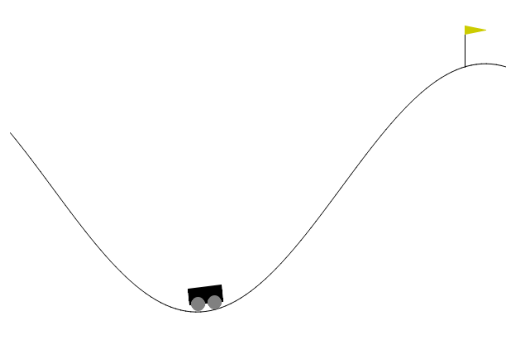

In [8]:
agent = CRandAgent()
results = agent.walk(max_length=20, render=True)
sum(results['r'])

In [9]:
# auxillary functions
def lin_ann_rate(i, n_total):
    return 1 - i / n_total

def exp_ann_rate(i, thr=0.0001, la=2/300, drop=0.001):
    """exponential decay with i --> +inf, provides descending values within range [expl_thr, 1],
        la=0.01 means ~36% left after 100 iterations, results < drop value are zeroed"""
    exp = np.exp if isinstance(i, np.ndarray) else torch.exp
    result = thr + (1 - thr) * exp(- la * i)
    if drop:
        result[result <= drop] = 0
    return result

In [15]:
class CrossEntropyNNCAgent(CRandAgent):
    def __init__(self, d_states=DIM_S, d_actions=DIM_A, hidden_d=(16, 4), device=DEVICE):
        """CrossEntropy algorithm actor, optimizes expected reward by policy, given by neural network"""
        super().__init__(d_actions)
        self.d_states = d_states
        self.var = 1
        
        self.loss = nn.MSELoss()
        self.device = device
        self.model = nn.Sequential(
            nn.Linear(in_features=self.d_states, out_features=hidden_d[0]),
            nn.ReLU(),
            nn.Linear(hidden_d[0], hidden_d[1]),
            nn.ReLU(),
            nn.Linear(hidden_d[1], d_actions))
        
        self.log = []
        self.hp = {}

    def act(self, state):
        """policy = action given by tanh(network output) + random normal(positive) noise within [0..1] 
            otherwise this policy would be almost completely deterministic (as NN is except its initialization)
            extra tanh here is just to fit result into action space min max limits"""
        with torch.inference_mode():
            action = nn.functional.tanh(nn.functional.tanh(self.model(torch.Tensor(state)).detach()) + self.var * torch.randn(self.d_actions))
            # torch.Tensor(self.d_actions).uniform_(0, 1)
            #torch.randn(self.d_actions)
        return action.numpy()

    def learning_curve(self, show_max=True, ax=None):
        """plots rewards vs iterations of algorithm"""
        ax = sns.lineplot(self.log, linewidth=1.0, ax=ax, label=f"lr={self.hp['lr']}")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_title(f"Mean reward over {self.hp['n_trajectories']} trajectories of length < {self.hp['max_length']}", fontsize = 10)
        ax.set_xlabel('iterations - 1')
        # ax.set_yscale('symlog')
        ax.legend()
        if show_max:
            ax.axhline(y=max(self.log), color='r', linestyle='-', linewidth=0.5)
        return ax
        
        
    def fit(self, n_iterations, max_n_epochs, noise_var=1, lr=0.01, n_trajectories=100, max_length=50, q=0.8, verbose=None):
        """
        CE Algorithm has 2 steps per iteration: evaluate policy, improve policy
        Our goal is to maximize expected reward ER which is unreachable => approximated
        
        n_trajectories (w/ length <= max_length) defines quality of ER approximation
        0<q<1 controls rejected quantile of trajectories

        max_n_epochs controls max possible NN training epochs per each iteration

        lr defines learning rate of built-in Adam optimizer
        
        verbose>0 sets up a period of learning process rendering

        NB: .fit internally uses .act method of child class(this), doesn't inherit parental
        """
        # save fitting hyperparameters for comparison
        ap = locals()
        self.hp = {k: ap[k] for k in ap.keys() - ['self', 'verbose', 'n_iterations', 'n_epochs']}
        self.model.to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        iterations_pbar = tqdm.trange(n_iterations, position=0, leave=True, colour="#a2d2ff")
        dh = display.display(display_id=True)
        var_0 = noise_var
        vars = []
        for i in iterations_pbar:
            self.model.eval()
            # policy evaluation (act with current policy or sample n_det deterministic from that one)
            trajectories = [self.walk(max_length=max_length) for t in range(n_trajectories)]
            rewards = np.stack([np.sum(t['r']) for t in trajectories])
            avg_reward = np.mean(rewards)
            self.log.append(avg_reward)

            # policy improvement
            # get q-quantile of current reward distribution and filter out better trajectories
            gamma = np.quantile(rewards, q)
            elite_ids = (rewards > gamma).nonzero()[0]
            if elite_ids.any():
                # extract (lists of) state and (corresponding) action tensors from elite trajectories
                states_l, actions_l = zip(*((np.stack(trajectories[ei]['s']), np.stack(trajectories[ei]['a'])) for ei in elite_ids))
                states, actions = torch.Tensor(np.concatenate(states_l)).to(self.device), torch.Tensor(np.concatenate(actions_l)).to(self.device)
                epochs_pbar = [0] if (max_n_epochs == 1 or i==0) else tqdm.trange(n_epochs, position=1, leave=False, colour="#ffc8dd") # order matters
                self.model.train()
                for e in epochs_pbar:
                    # forward pass
                    pred_actions = self.model(states)
                    loss = self.loss(pred_actions, actions)
                    # backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                # noise variance (descends from var_0 to 0)
                self.var = var_0 * lin_ann_rate(i, n_total=n_iterations)
                vars.append(self.var)
                # less stochastic gradients (ascending from 1 to max_n_epochs)
                n_epochs = 1 + round((1 - exp_ann_rate(torch.Tensor([i]), thr=0, la=2/n_iterations, drop=None).item()) * (max_n_epochs - 1))
                iterations_pbar.set_postfix_str(f'avg reward: {avg_reward.item():.2f}, loss: {loss.detach().item():.2e}, var: {self.var:.2f}, n_epochs: {n_epochs}', refresh=True)
            
            # visualization (plotting starts after at least 1 iteration)
            if verbose and i > 0 and (i + 1) % verbose == 0:
                # print(f"iteration {i + 1}, mean total reward: {avg_reward}")
                figure, axes = plt.subplots(1, 2, figsize=(12,5))
                ax = self.learning_curve(ax=axes[0])
                
                ax2 = ax.twinx()
                ax2.tick_params(axis='y', labelcolor='slateblue')
                sns.lineplot(vars, linewidth=0.5, ax=ax2, label="variance", color='slateblue')
                
                ax = sns.histplot(rewards, kde=False, bins=20, ax=axes[1])
                ax.axvline(gamma, 0, 20, color='r')
                ax.set_xlabel('Rewards')
                ax.set_title(f'Current distribution of rewards and its {q:.2f}-quantile ', fontsize = 10)
                
                dh.update(plt.gcf())
                plt.close() # because plt.clf() is spurious
        return avg_reward

In [ ]:
agent_nnc = CrossEntropyNNCAgent()
agent_nnc.fit(n_iterations=100, max_n_epochs=10, noise_var=1, lr=0.01, n_trajectories=60, max_length=1000, q=0.8, verbose=1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
results = agent_nnc.walk(max_length=100, render=False)
sum(results['r'])